In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import warnings
import matplotlib.cm as cm
import matplotlib.lines as mlines
from tqdm import tqdm
warnings.filterwarnings("ignore")

# MVKDR

In [5]:
from ConsensusClusteringMVKDR import ConsensusCluster
import sys
sys.path.append('../MvKDR-master/code/')
from mvkdr import mvkdr
from utility import mediandist
data_path = 'data'
result_path = '{}/MVKDR_results/'.format(data_path)

## proteome first

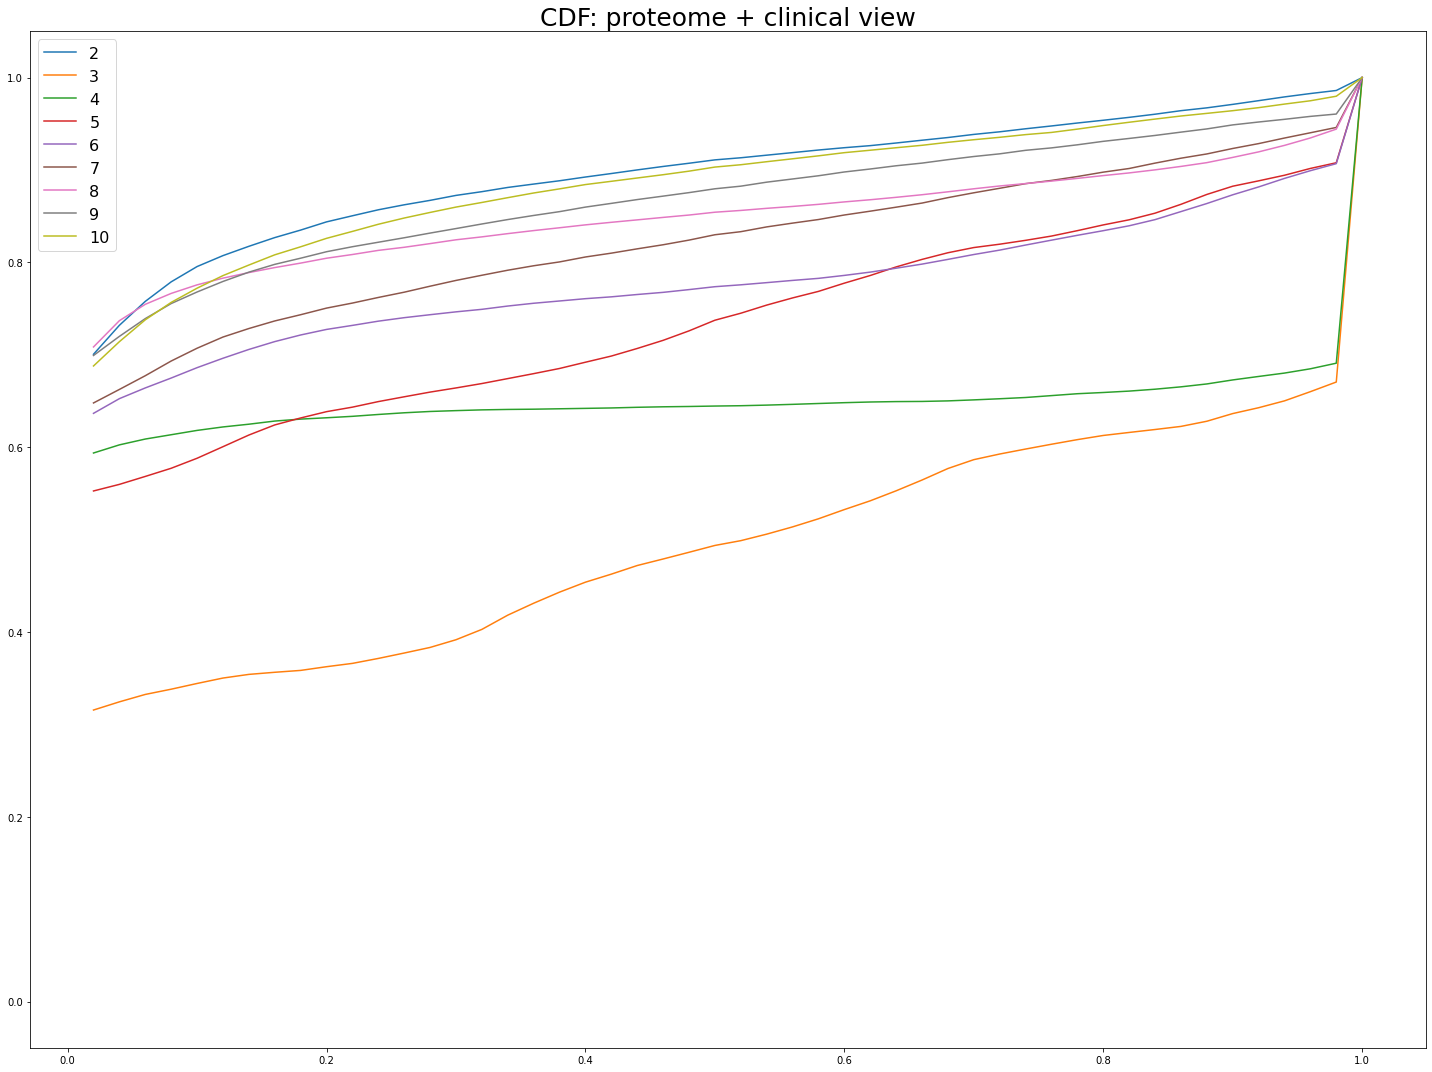

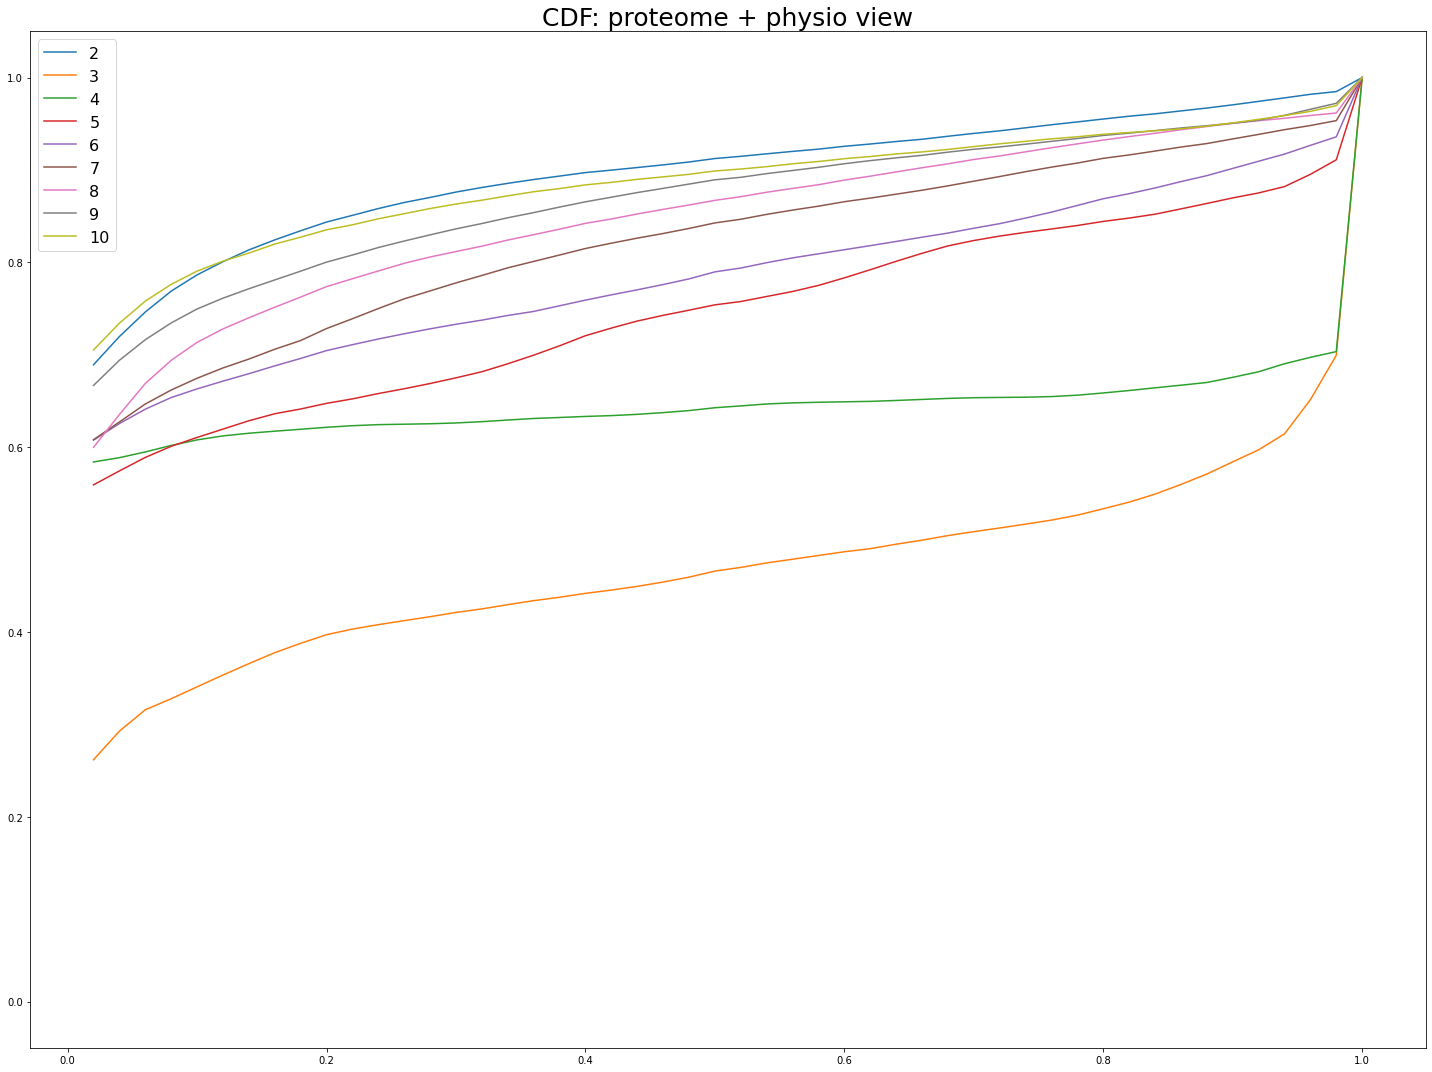

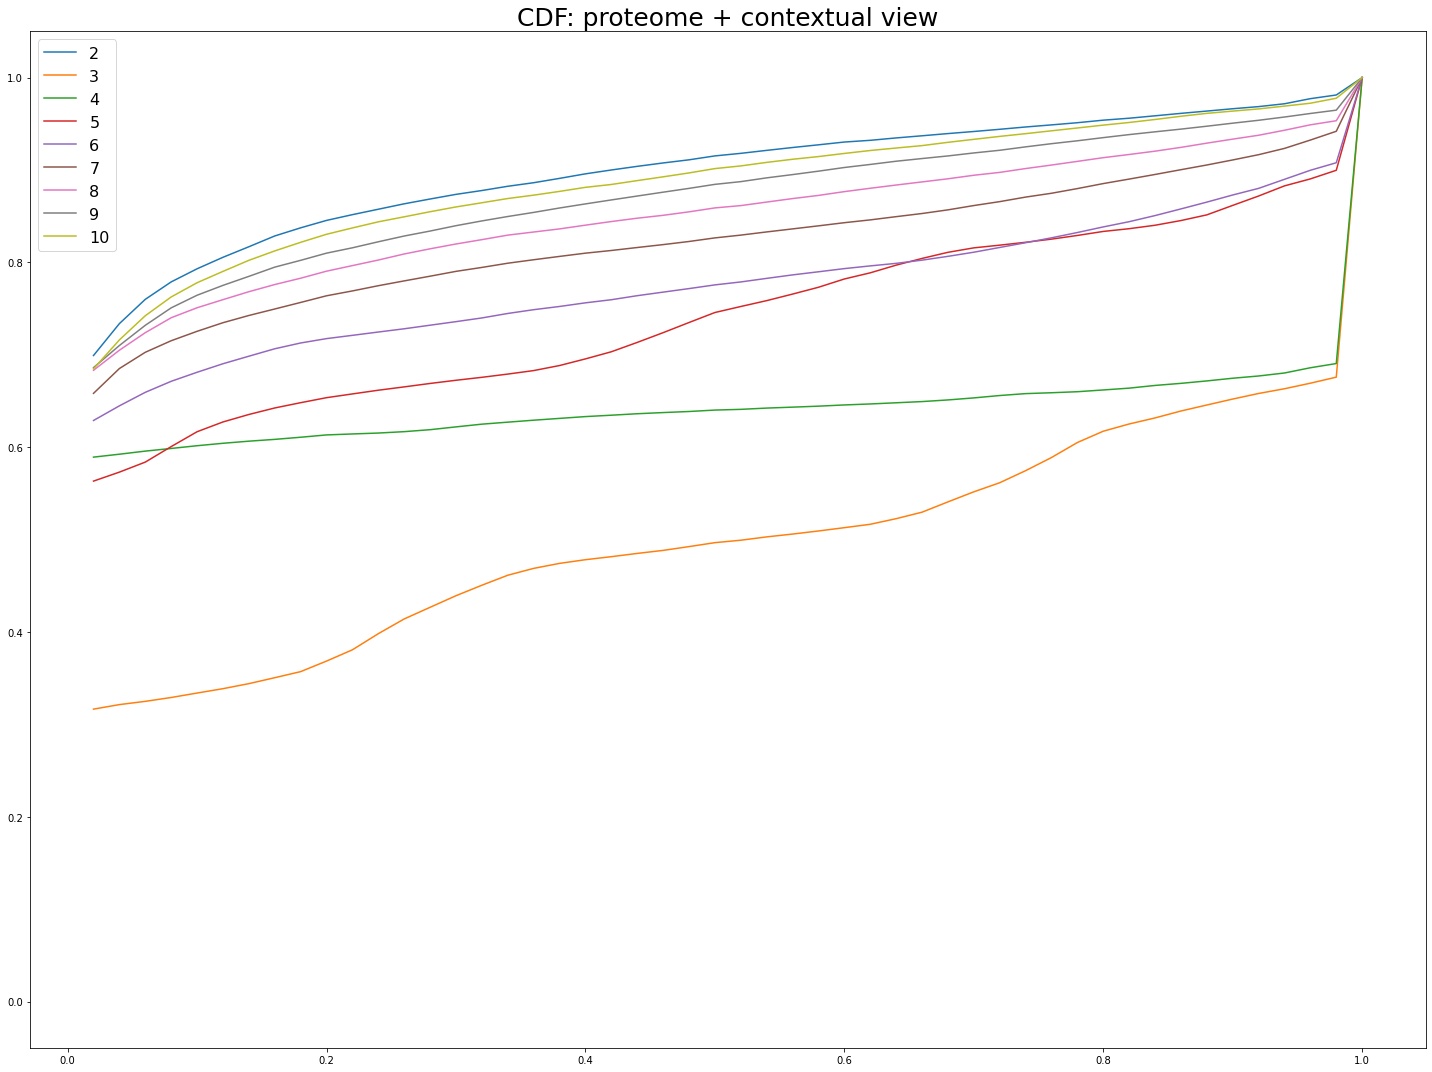

In [3]:
for view in ['clinical', 'physio', 'contextual']:
    Mks = pd.read_pickle('data/MVKDR_results/proteome_{}_K_2_10.pkl'.format(view))
    
    Aks = []
    plt.figure(figsize=(20, 15))
    for KCC_space in range(2, 11):
        hist, bins = np.histogram(Mks[KCC_space - 3].ravel(), bins=50)
        pdf = hist / sum(hist)
        cdf = np.cumsum(pdf)
        acdf = np.sum(h * (b - a) for b, a, h in zip(bins[1:], bins[:-1], cdf))
        Aks.append(acdf)
        plt.plot(bins[1:], cdf, label=KCC_space)
    plt.legend(fontsize=16)
    plt.title("CDF: proteome + {} view".format(view), fontsize=25)

    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig(
        "data/MVKDR_results/CDF_proteome_{}_view.png".format(view),
        dpi=300,
    )
    plt.show()

### selected:
**clinical: 4**

**physio: 4**

**contextual: 4**


In [4]:
Ks = {'clinical':4, 'physio':4, 'contextual':4}

In [16]:
for view in ['clinical']:
    k = Ks[view]
    proteome = pd.read_csv("{}/ProteomeViewStandardized.csv".format(data_path), index_col=0)
    ids = proteome.index
    contextual = pd.read_csv("{}/ContextualViewStandardized.csv".format(data_path), index_col=0)
    physio = pd.read_csv("{}/PhysioViewStandardized.csv".format(data_path), index_col=0)
    clinical = pd.concat([physio, contextual], 1)
    if view == 'clinical':
        add_view = clinical
    elif view == 'contextual':
        add_view = contextual
    elif view == 'physio':
        add_view = physio
        
    sigma1 = mediandist(proteome.values)
    sigma2 = mediandist(add_view.values)
    
    y_pred, km_obj, U = mvkdr(proteome.values, add_view.values, k, sigma1, sigma2, 0.1, 0.1, 10)
    
    y_pred = pd.Series(y_pred, index=ids)
    y_pred.to_csv('{}/proteome_{}_K_{}_assignments.csv'.format(result_path, view, k))
    U = pd.DataFrame(U, index=ids, columns=['Space {}'.format(i+1) for i in range(U.shape[1])])
    U.to_csv('{}/proteome_{}_K_{}_projections.csv'.format(result_path, view, k))

In [24]:
y_pred

BE-001    1
BE-003    2
BE-004    3
BE-005    0
BE-007    1
         ..
ZH-254    2
ZH-255    2
ZH-257    0
ZH-258    0
ZH-259    0
Length: 358, dtype: int32

## search best TSNE embedding

In [16]:
perplexitys = [5, 10, 20, 30, 50, 80, 100]
random_states = np.arange(10)
TSNE_grids = list(product(perplexitys, random_states))
assignment = pd.read_csv(
    "{}/proteome_clinical_K_4_assignments_ranked.csv".format(result_path),
    index_col=0,
)
assignment = assignment["assignment"]
tsne_perf = pd.DataFrame(columns=["perplexity", "random_state", "silhouette_score"])

cmap = cm.rainbow(np.linspace(0, 1, len(np.unique(assignment))))
colors = np.array([cmap[i - 1] for i in assignment])
U = pd.read_csv(
    "{}/proteome_clinical_K_4_projections.csv".format(result_path), index_col=0
)

  0%|                                                    | 0/70 [00:00<?, ?it/s]

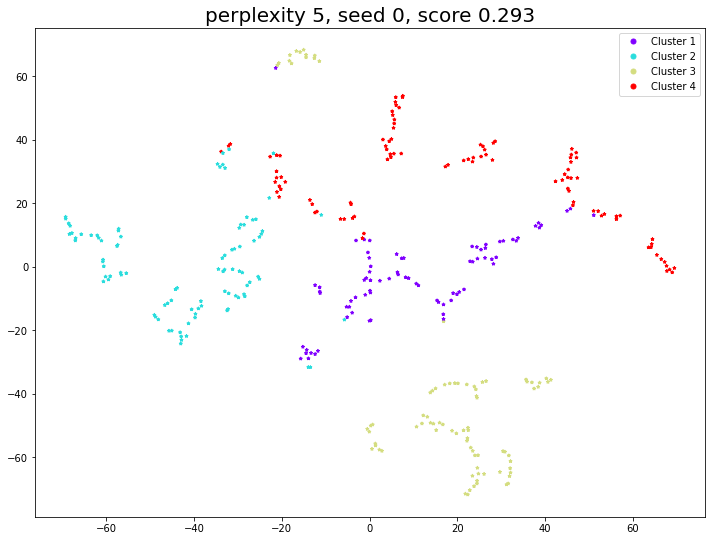

  1%|▋                                           | 1/70 [00:23<27:20, 23.78s/it]

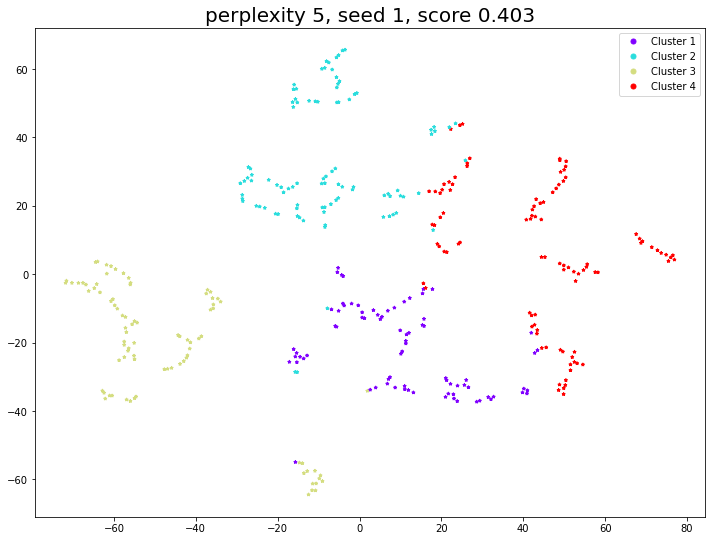

  3%|█▎                                          | 2/70 [00:51<29:40, 26.18s/it]

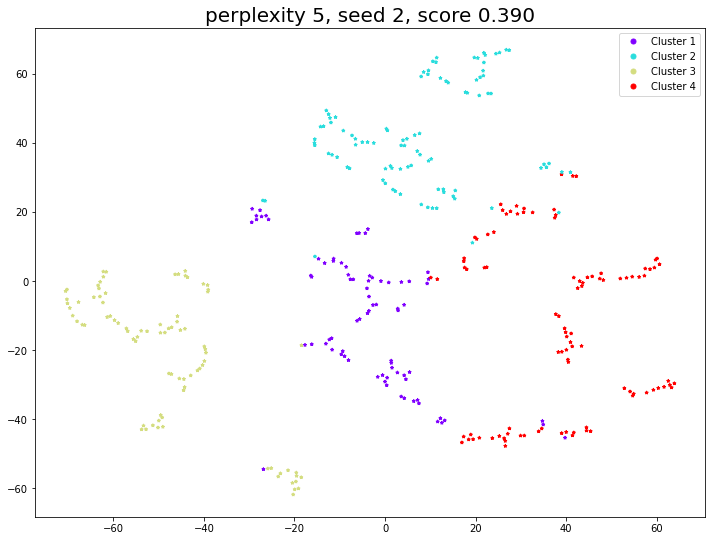

  4%|█▉                                          | 3/70 [01:11<25:49, 23.12s/it]

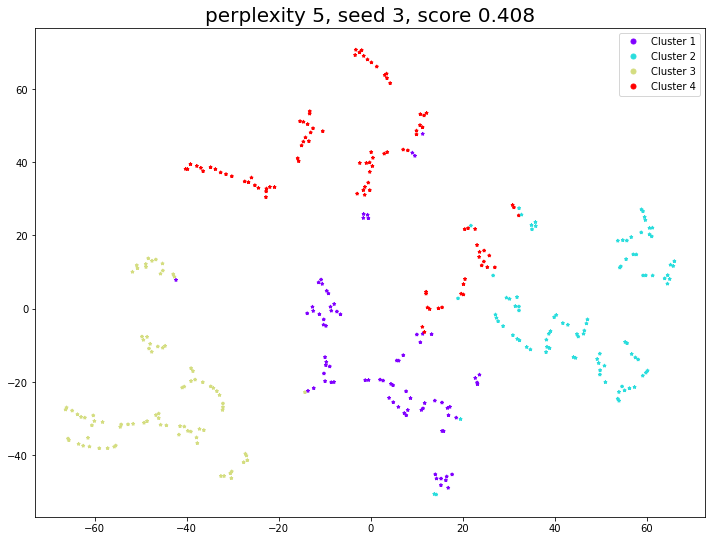

  6%|██▌                                         | 4/70 [01:25<21:43, 19.75s/it]

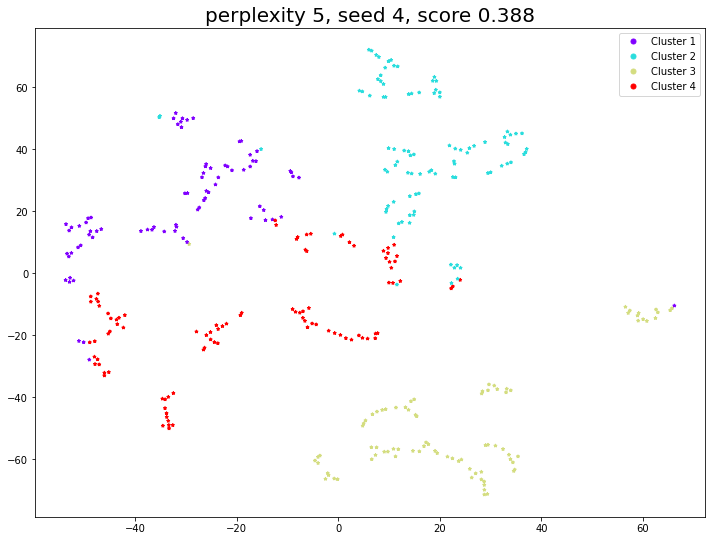

  7%|███▏                                        | 5/70 [01:39<19:02, 17.57s/it]

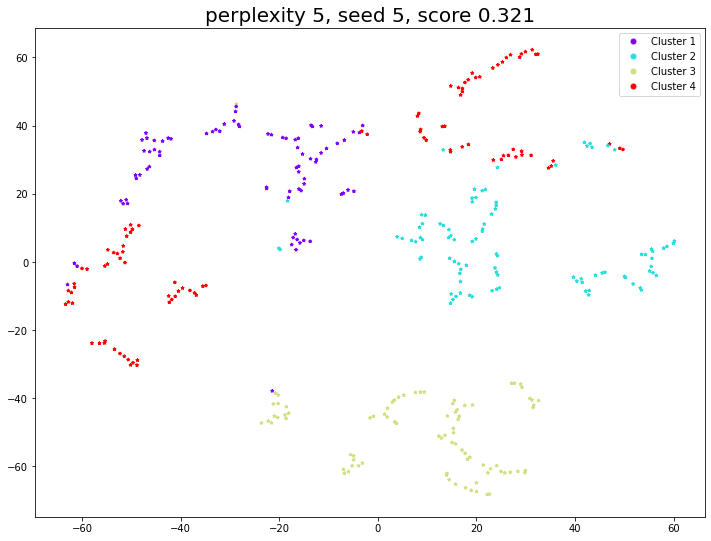

  9%|███▊                                        | 6/70 [02:08<23:05, 21.64s/it]

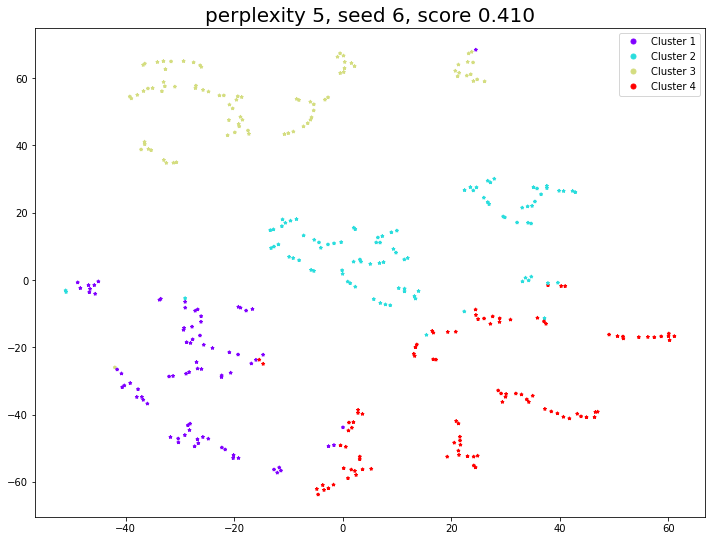

 10%|████▍                                       | 7/70 [02:26<21:25, 20.40s/it]

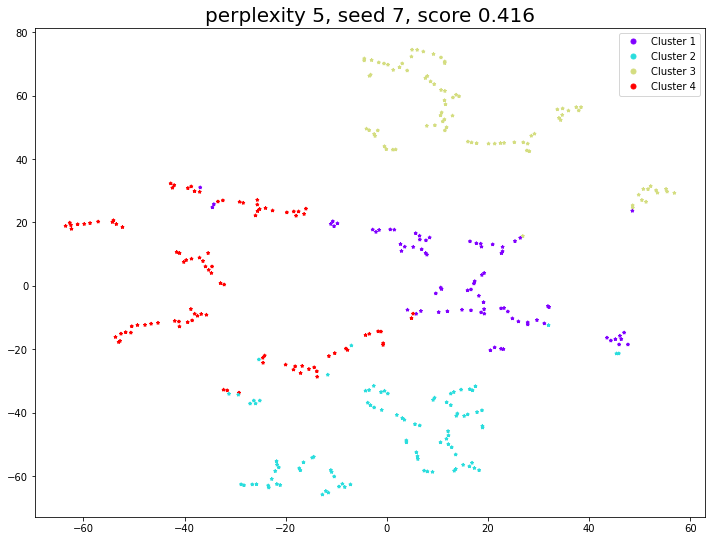

 11%|█████                                       | 8/70 [02:41<19:03, 18.44s/it]

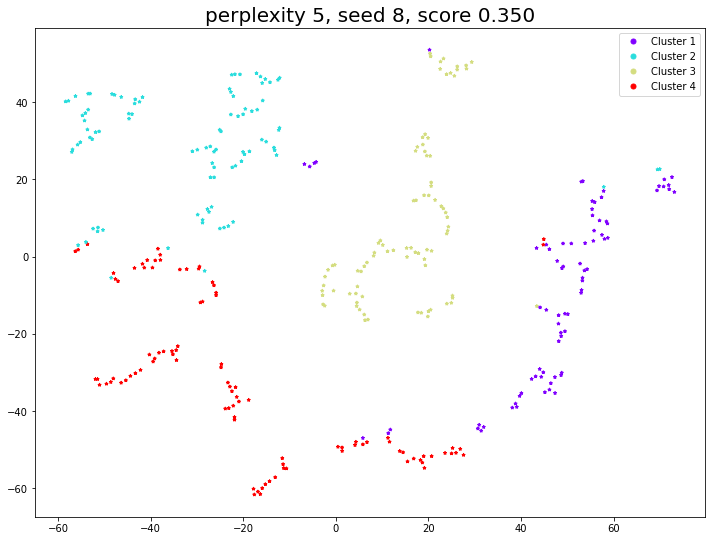

 13%|█████▋                                      | 9/70 [03:00<19:09, 18.84s/it]

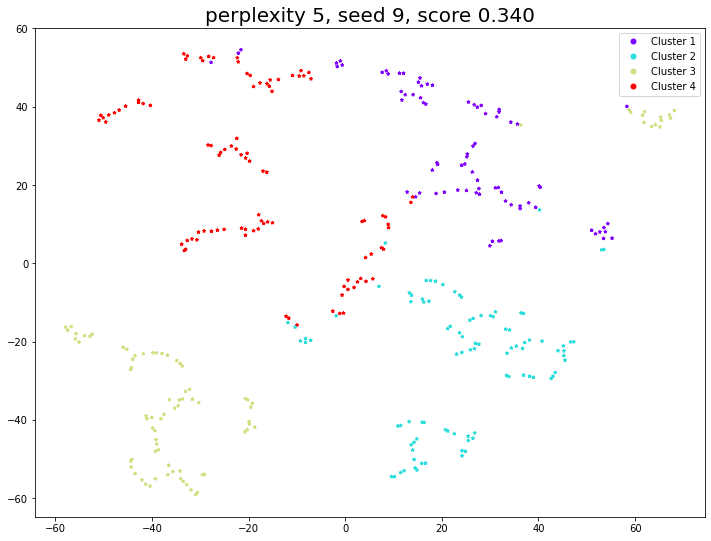

 14%|██████▏                                    | 10/70 [03:18<18:39, 18.65s/it]

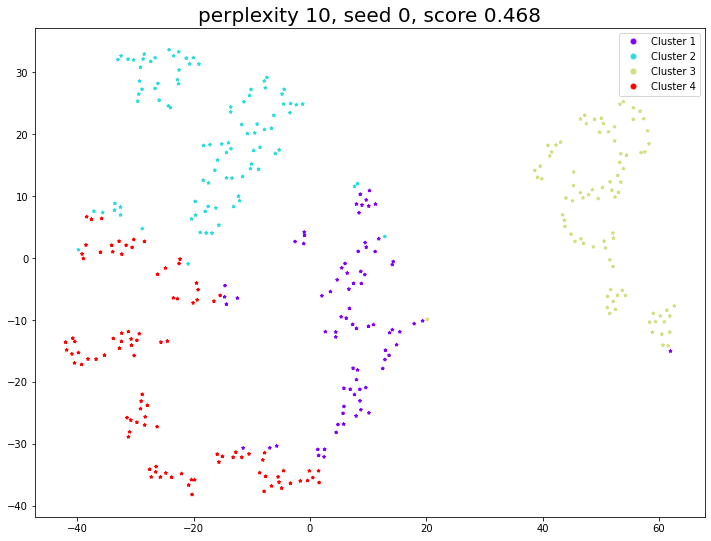

 16%|██████▊                                    | 11/70 [03:47<21:19, 21.69s/it]

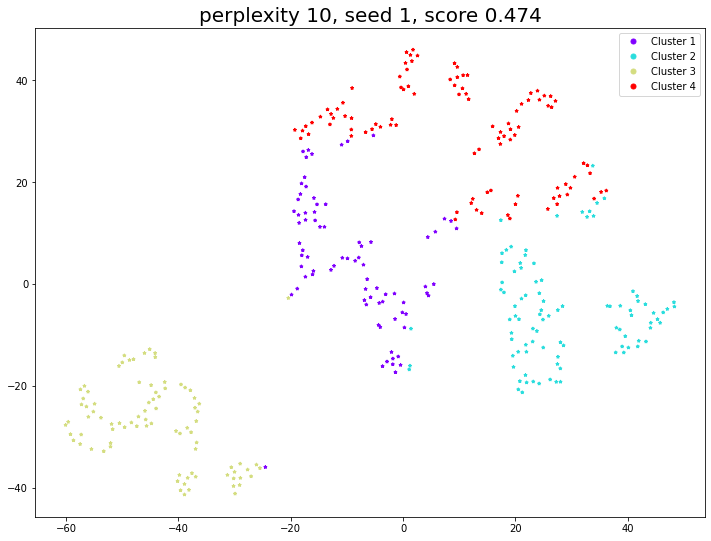

 17%|███████▎                                   | 12/70 [04:12<21:47, 22.54s/it]

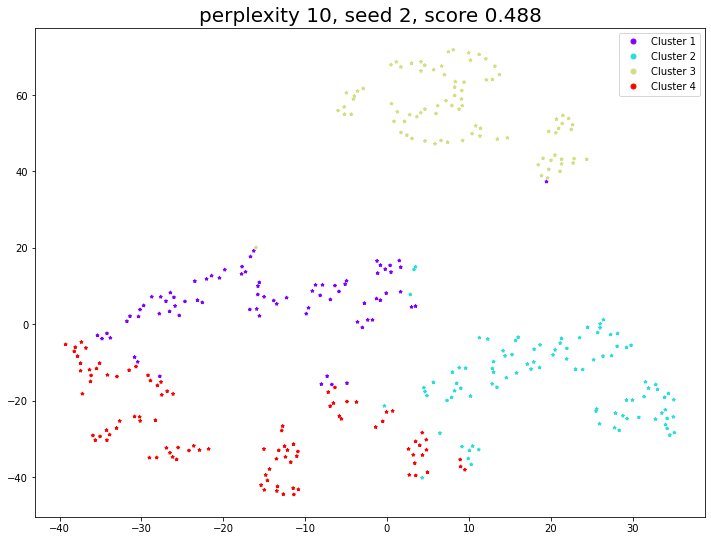

 19%|███████▉                                   | 13/70 [04:34<21:24, 22.53s/it]

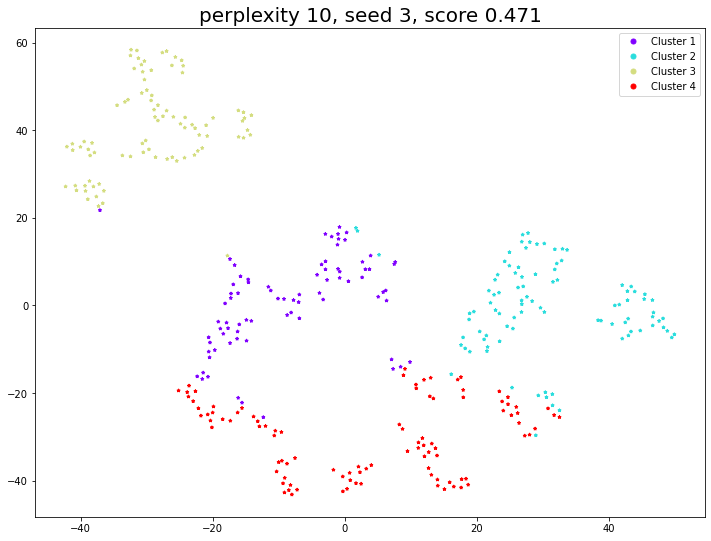

 20%|████████▌                                  | 14/70 [04:55<20:37, 22.09s/it]

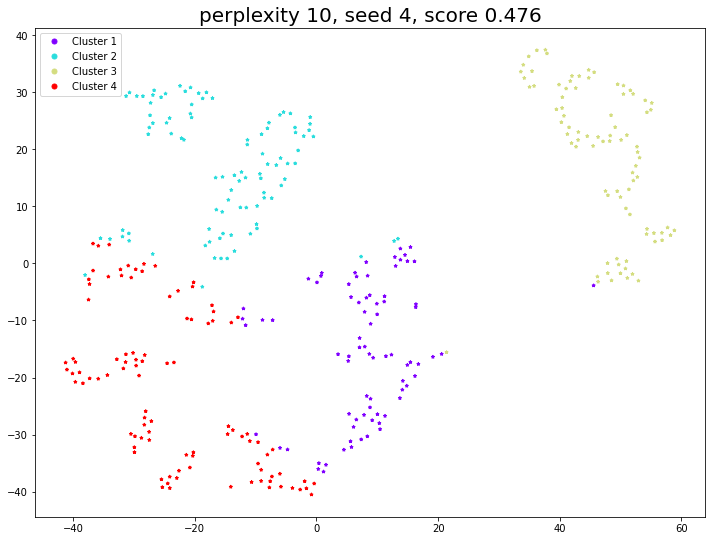

 21%|█████████▏                                 | 15/70 [05:15<19:35, 21.37s/it]

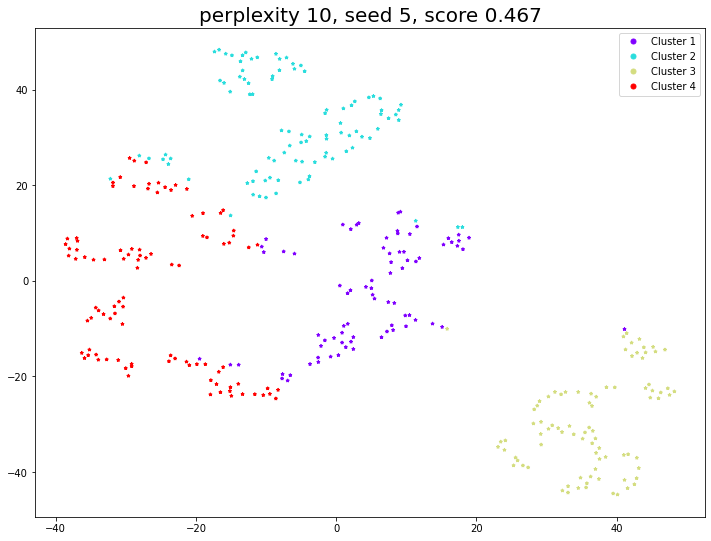

 23%|█████████▊                                 | 16/70 [05:37<19:33, 21.73s/it]

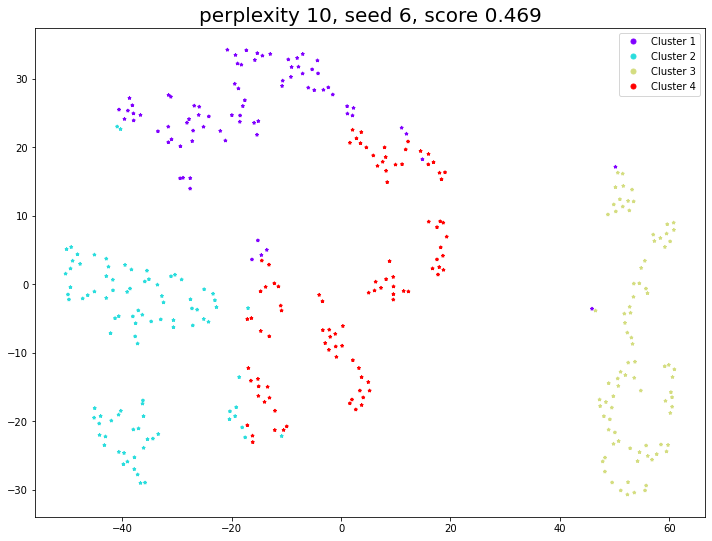

 24%|██████████▍                                | 17/70 [05:56<18:19, 20.75s/it]

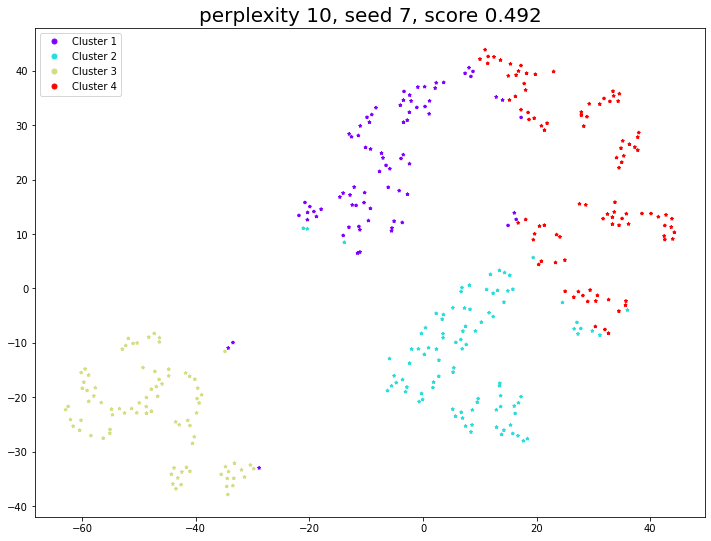

 26%|███████████                                | 18/70 [06:21<19:02, 21.97s/it]

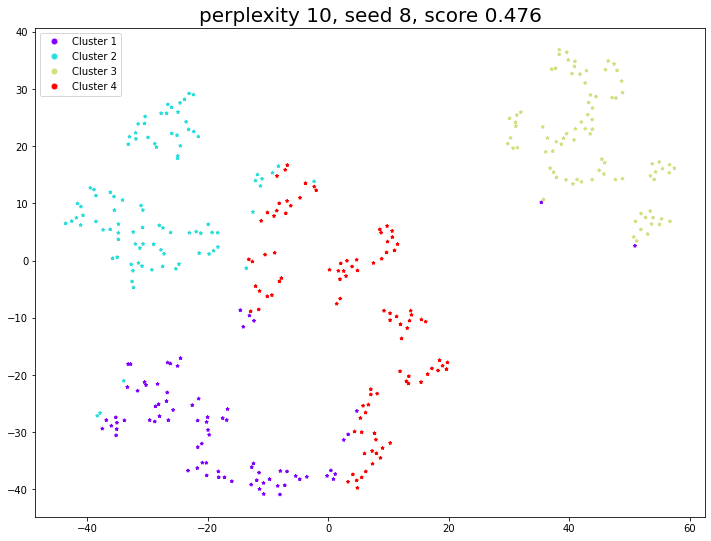

 27%|███████████▋                               | 19/70 [06:46<19:36, 23.07s/it]

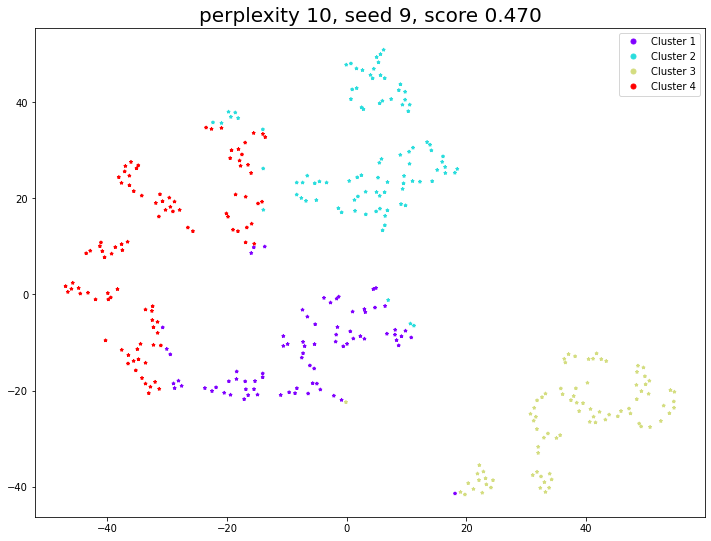

 29%|████████████▎                              | 20/70 [07:11<19:41, 23.64s/it]

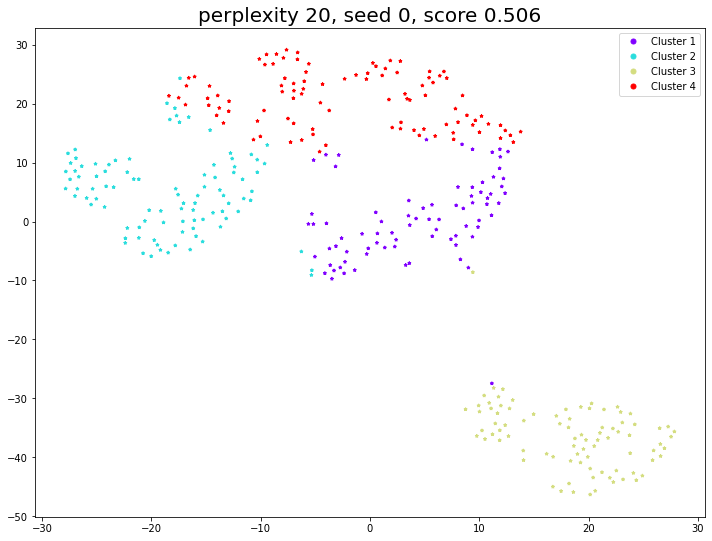

 30%|████████████▉                              | 21/70 [07:28<17:41, 21.67s/it]

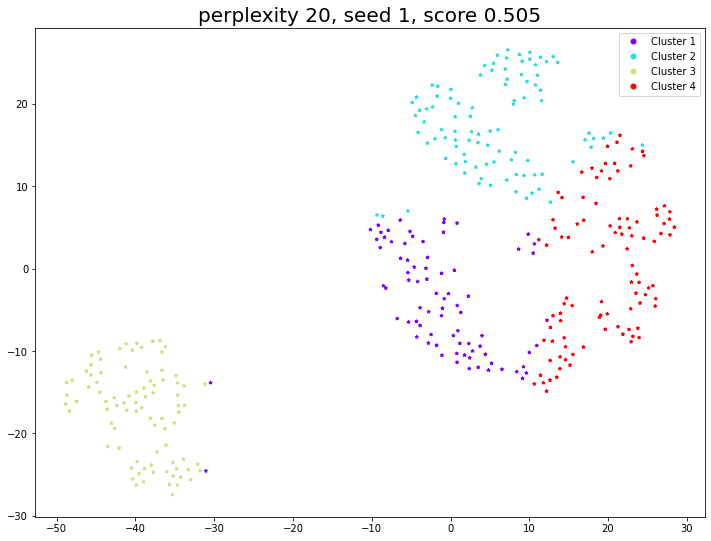

 31%|█████████████▌                             | 22/70 [07:41<15:07, 18.90s/it]

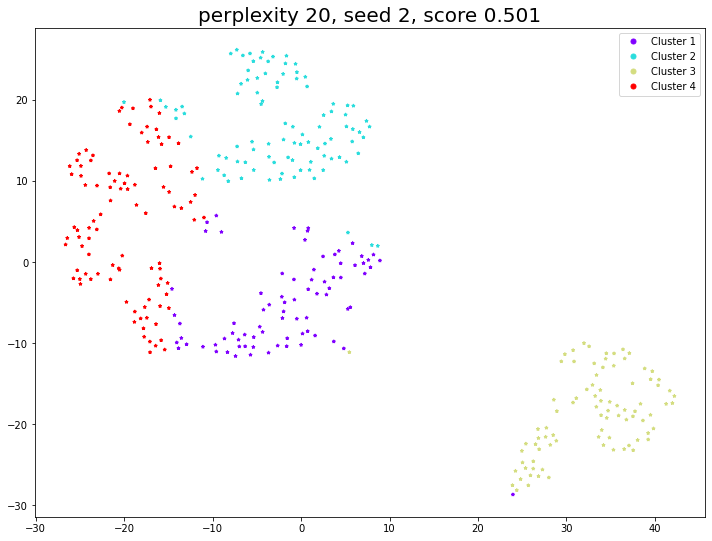

 33%|██████████████▏                            | 23/70 [07:42<10:34, 13.50s/it]

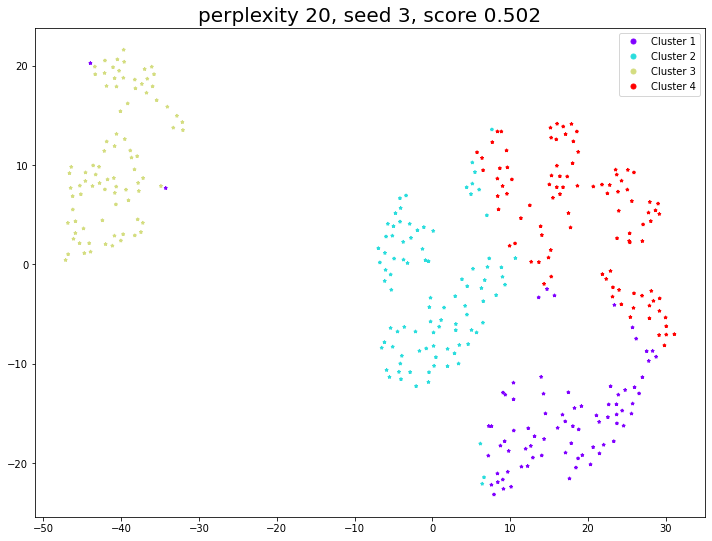

 34%|██████████████▋                            | 24/70 [07:43<07:31,  9.81s/it]

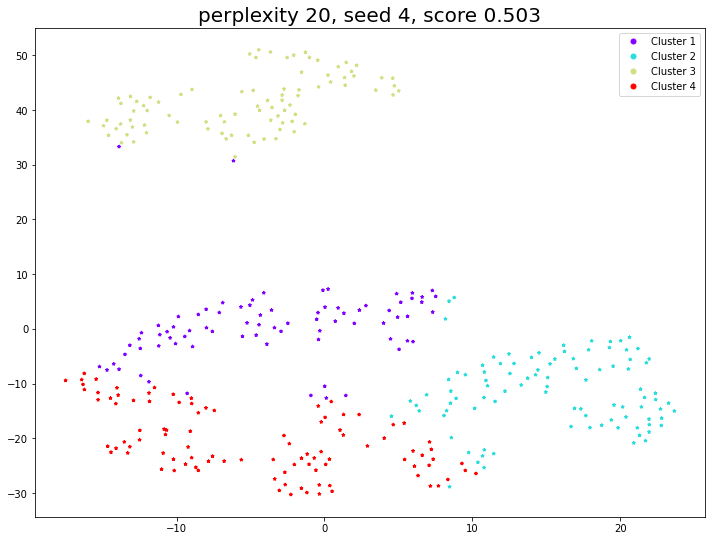

 36%|███████████████▎                           | 25/70 [07:51<07:00,  9.34s/it]

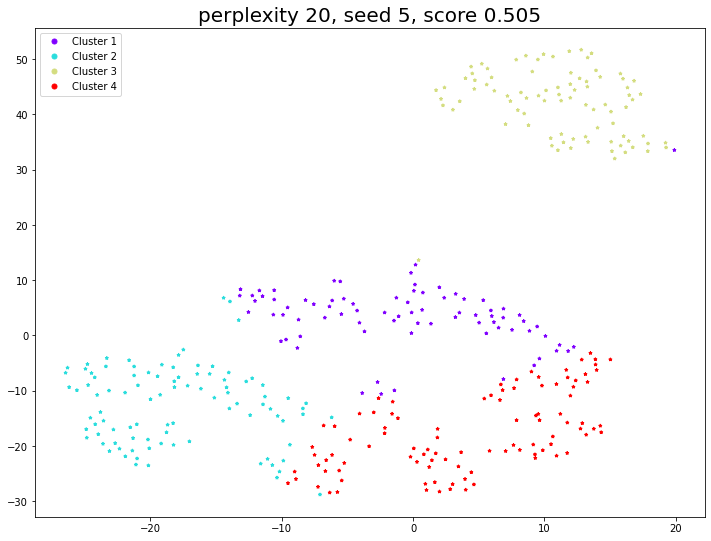

 37%|███████████████▉                           | 26/70 [08:12<09:23, 12.80s/it]

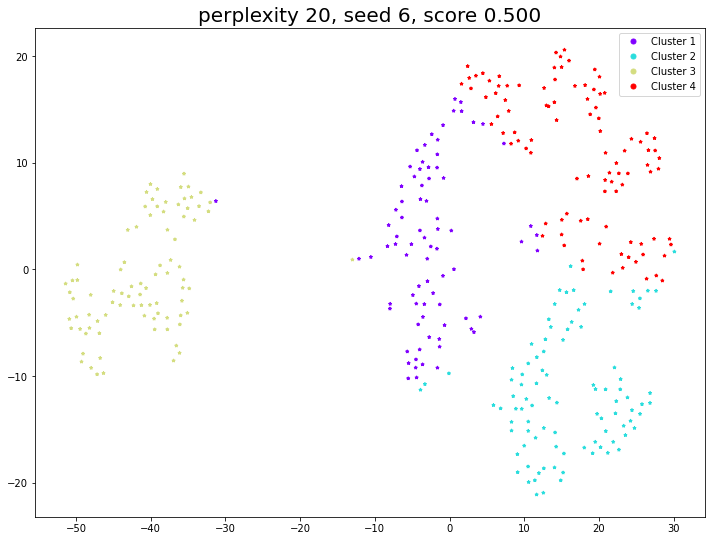

 39%|████████████████▌                          | 27/70 [08:34<11:11, 15.63s/it]

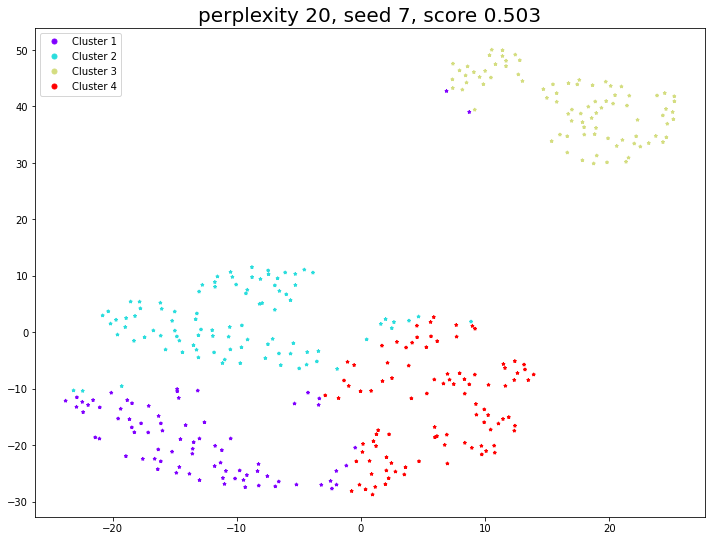

 40%|█████████████████▏                         | 28/70 [09:06<14:18, 20.45s/it]

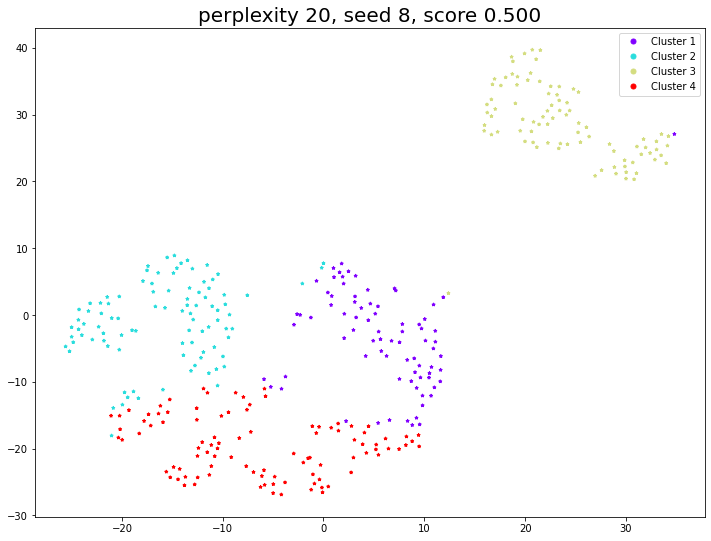

 41%|█████████████████▊                         | 29/70 [09:23<13:10, 19.29s/it]

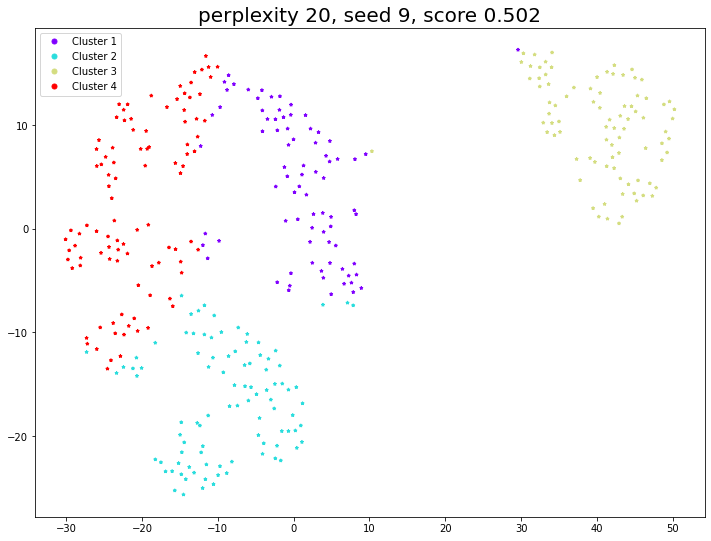

 43%|██████████████████▍                        | 30/70 [09:48<14:05, 21.13s/it]

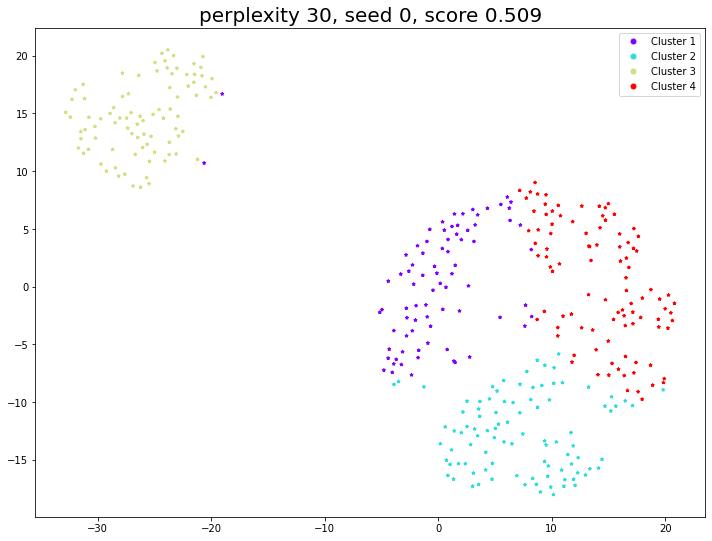

 44%|███████████████████                        | 31/70 [10:12<14:21, 22.08s/it]

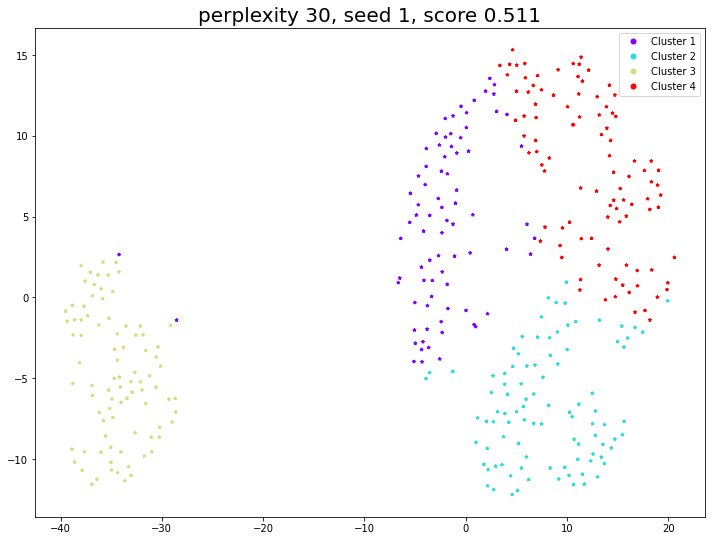

 46%|███████████████████▋                       | 32/70 [10:46<16:11, 25.55s/it]

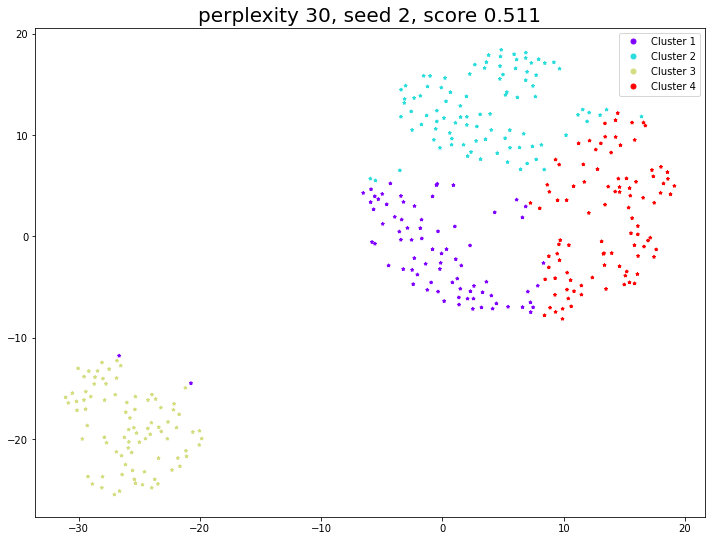

 47%|████████████████████▎                      | 33/70 [11:10<15:28, 25.09s/it]

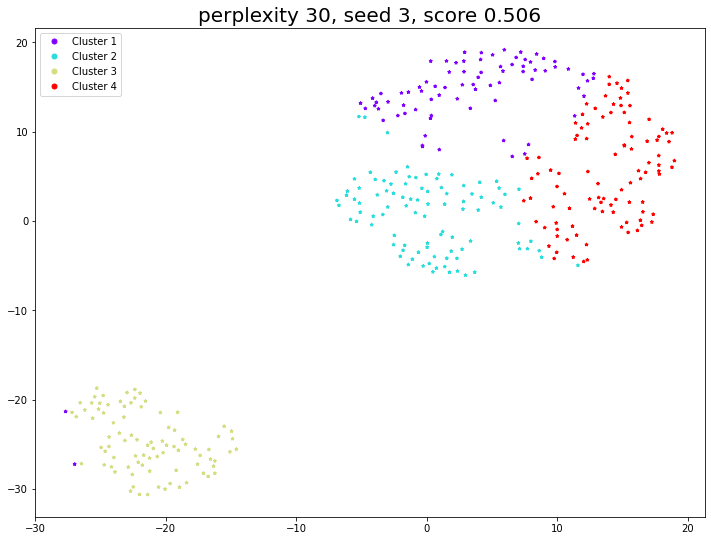

 49%|████████████████████▉                      | 34/70 [11:39<15:48, 26.36s/it]

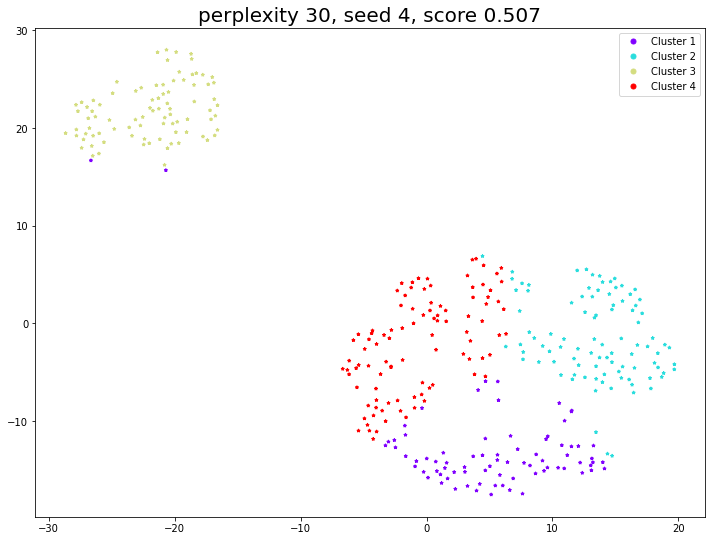

 50%|█████████████████████▌                     | 35/70 [12:01<14:29, 24.83s/it]

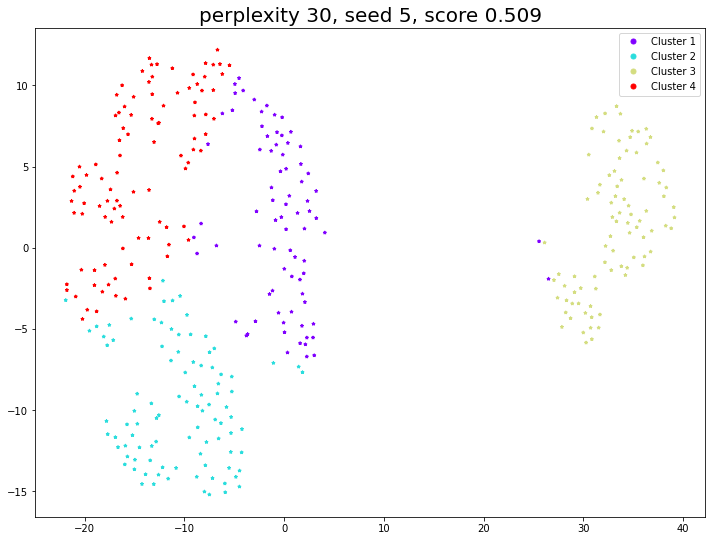

 51%|██████████████████████                     | 36/70 [12:25<14:03, 24.81s/it]

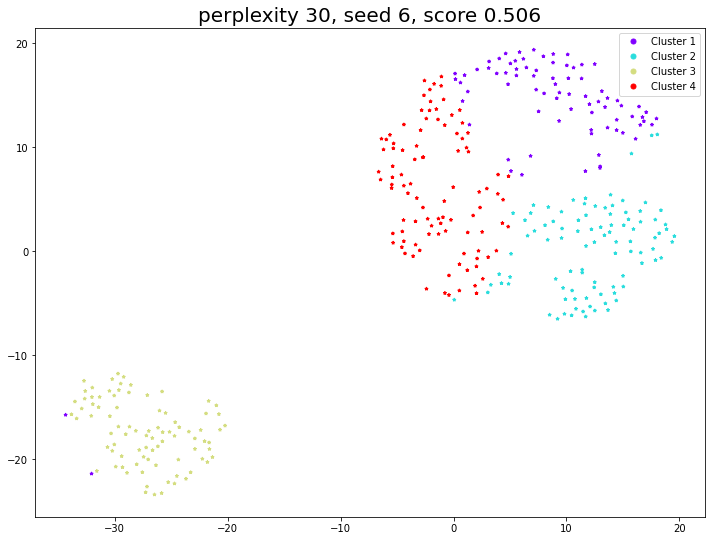

 53%|██████████████████████▋                    | 37/70 [12:44<12:34, 22.88s/it]

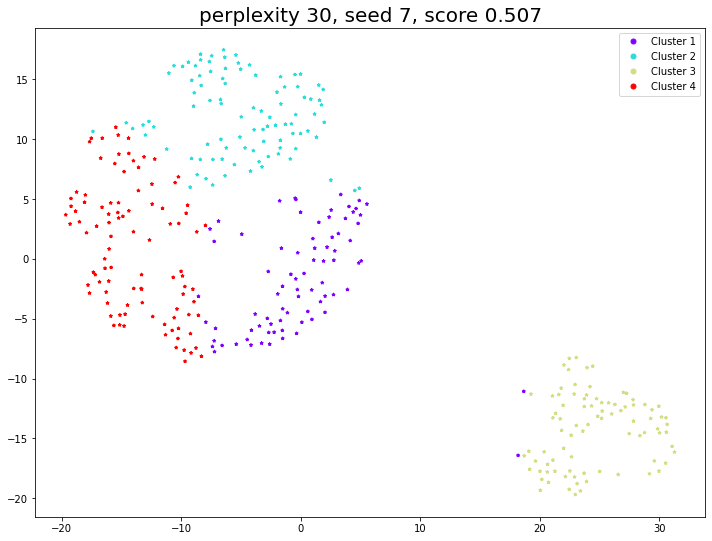

 54%|███████████████████████▎                   | 38/70 [13:04<11:50, 22.22s/it]

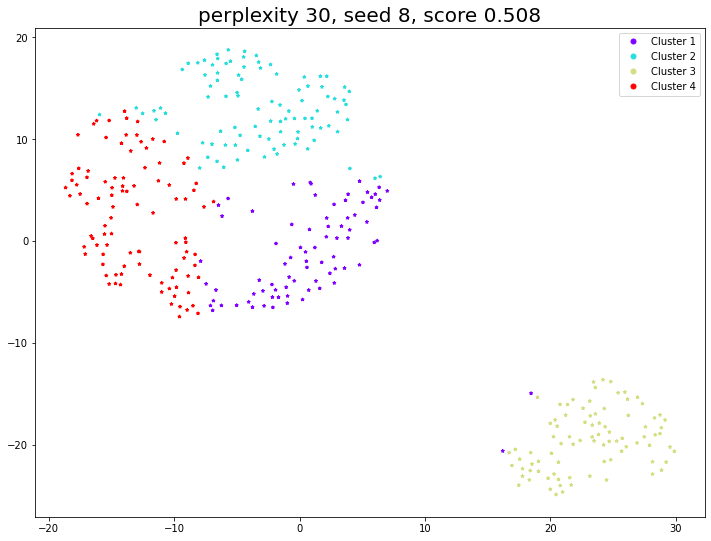

 56%|███████████████████████▉                   | 39/70 [13:34<12:37, 24.42s/it]

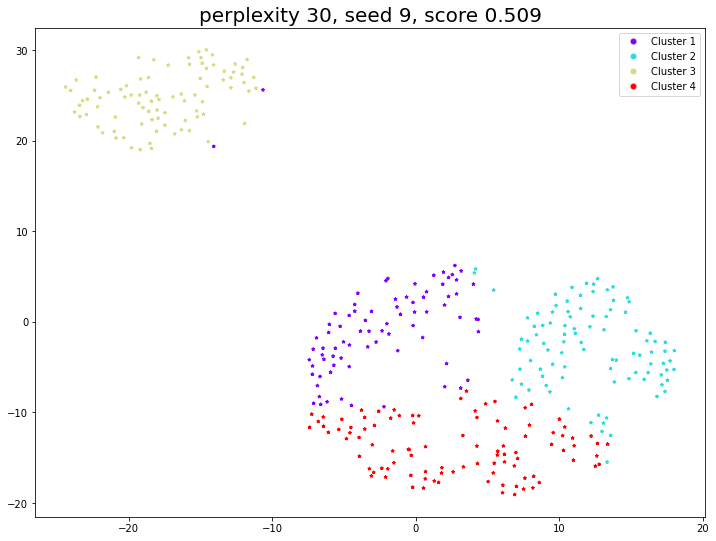

 57%|████████████████████████▌                  | 40/70 [13:52<11:18, 22.62s/it]

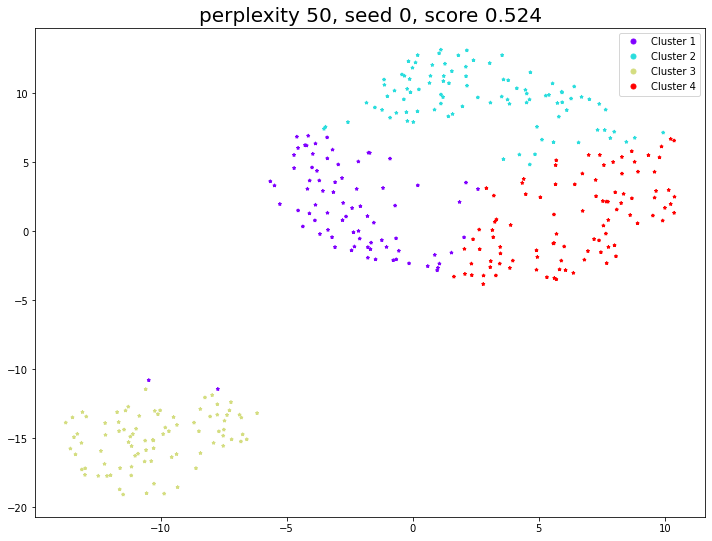

 59%|█████████████████████████▏                 | 41/70 [14:17<11:17, 23.36s/it]

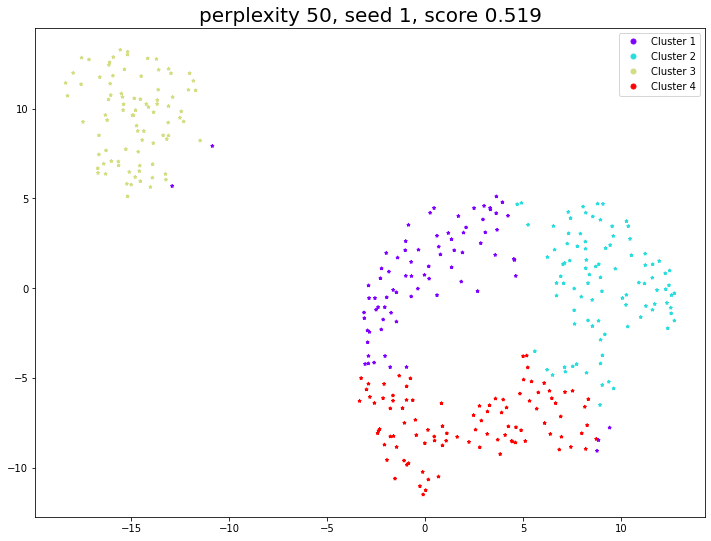

 60%|█████████████████████████▊                 | 42/70 [14:41<10:55, 23.41s/it]

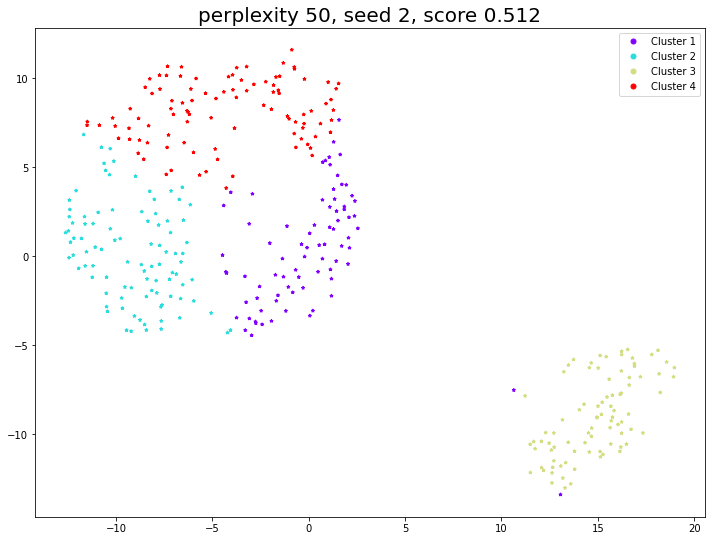

 61%|██████████████████████████▍                | 43/70 [15:04<10:30, 23.36s/it]

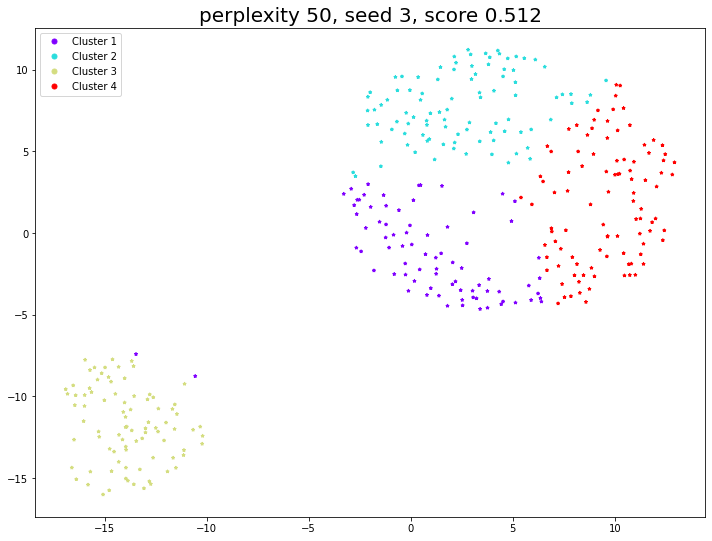

 63%|███████████████████████████                | 44/70 [15:38<09:14, 21.33s/it]


KeyboardInterrupt: 

In [19]:
best_score, best_emb = 0, 0
i = 0
for TSNE_param in tqdm(TSNE_grids):
    perplexity, random_state = TSNE_param
    tsne = TSNE(
        perplexity=perplexity, random_state=random_state, n_components=2
    )
    X_emb = tsne.fit_transform(U.values)
    score = silhouette_score(X_emb, assignment)
    tsne_perf.loc[i] = [perplexity, random_state, score]
    i += 1
    
    plt.figure(figsize=(12, 9))
    legends = []
    
    for i in range(len(np.unique(assignment))):
        legends.append(
            mlines.Line2D(
                [],
                [],
                color=cmap[i],
                marker=".",
                linestyle="None",
                markersize=10,
                label="Cluster {}".format(i + 1),
            )
        )

    plt.scatter(
        X_emb[:, 0],
        X_emb[:, 1],
        color=colors,
        s=10,
        marker="*",
    )
    plt.title(
        "perplexity {}, seed {}, score {:.3f}".format(perplexity, random_state, score),
        fontsize=20,
    )
    plt.legend(handles=legends, fontsize=10)
    plt.show()

  0%|                                                    | 0/70 [00:00<?, ?it/s]

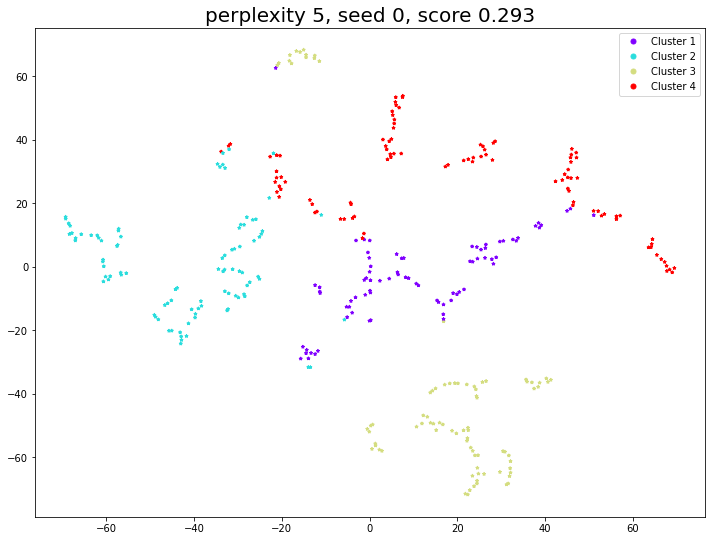

  1%|▋                                           | 1/70 [00:24<28:07, 24.46s/it]

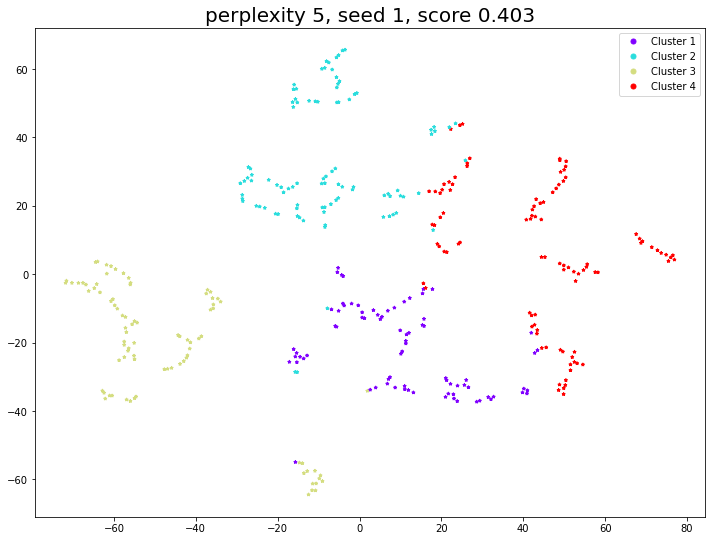

  3%|█▎                                          | 2/70 [00:25<11:58, 10.57s/it]

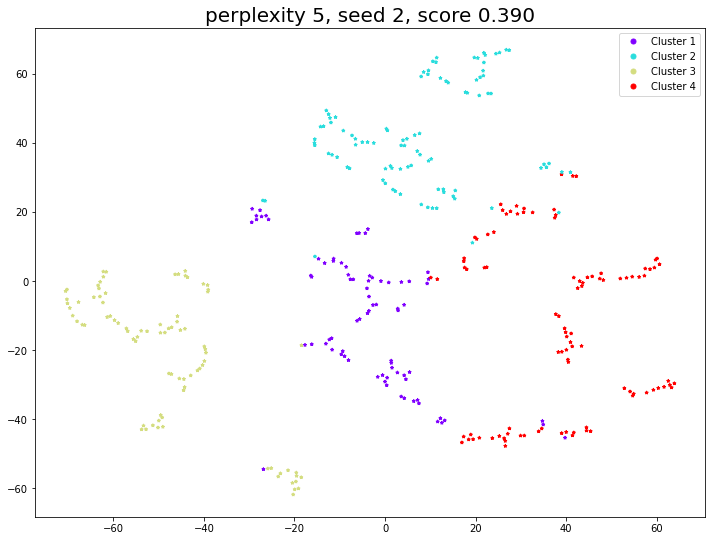

  4%|█▉                                          | 3/70 [00:26<06:49,  6.12s/it]

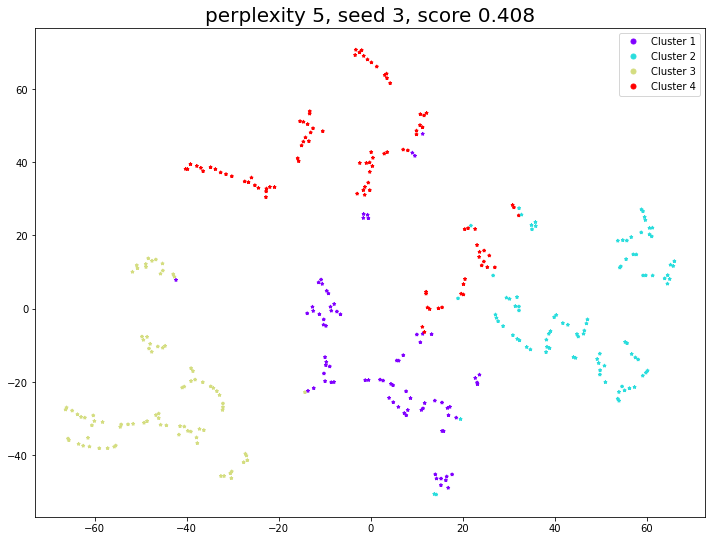

  6%|██▌                                         | 4/70 [00:27<04:29,  4.09s/it]

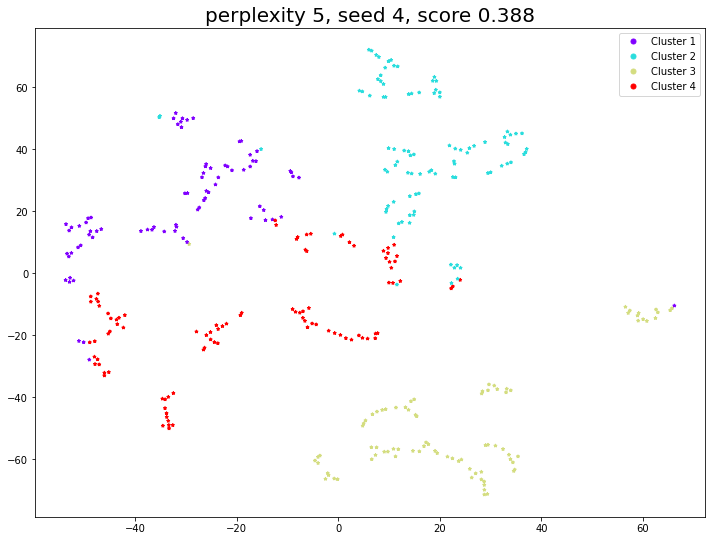

  7%|███▏                                        | 5/70 [00:35<06:00,  5.55s/it]

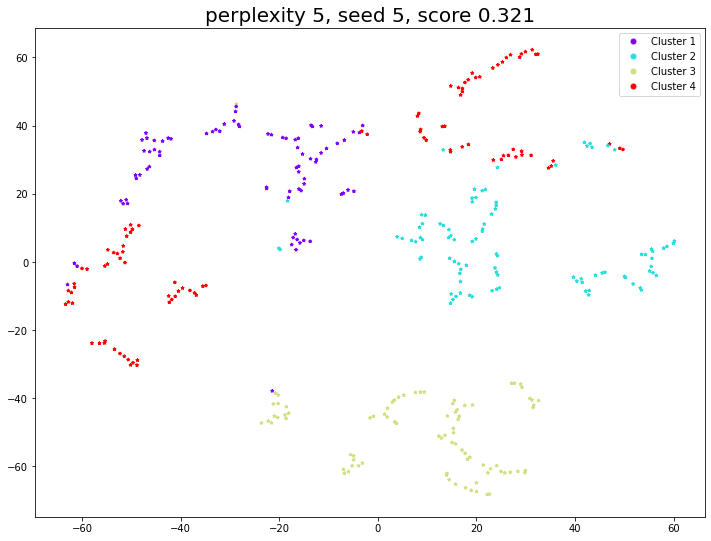

  9%|███▊                                        | 6/70 [01:02<13:46, 12.92s/it]

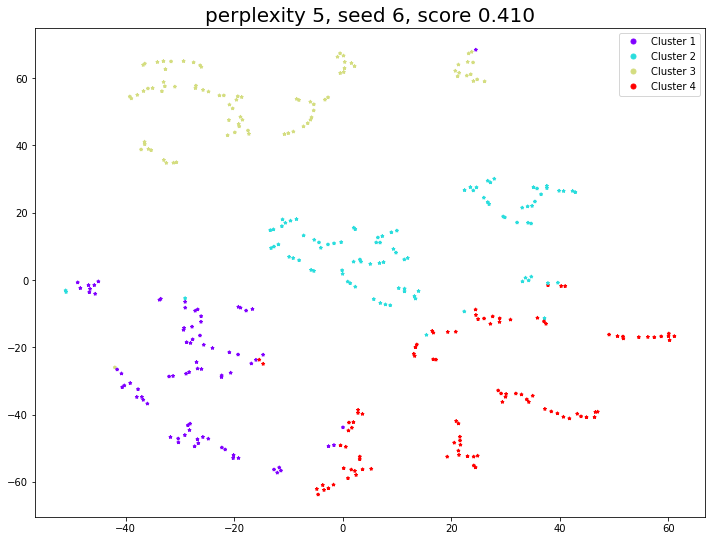

 10%|████▍                                       | 7/70 [01:35<20:38, 19.65s/it]

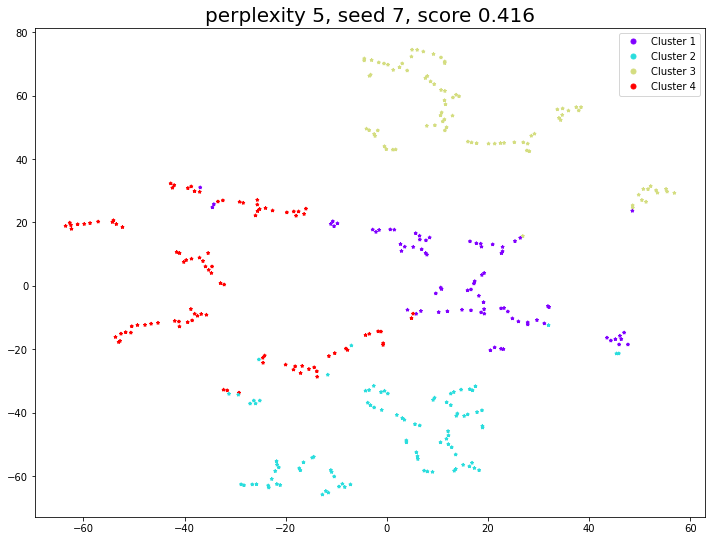

 11%|█████                                       | 8/70 [02:12<17:05, 16.55s/it]


KeyboardInterrupt: 

In [27]:
best_score, best_emb = 0, 0
i = 0
assignment = pd.read_csv(
    "{}/proteome_clinical_K_4_assignments.csv".format(result_path),
    index_col=0,
)
assignment = (assignment["0"]+1).tolist()
for TSNE_param in tqdm(TSNE_grids):
    perplexity, random_state = TSNE_param
    tsne = TSNE(
        perplexity=perplexity, random_state=random_state, n_components=2
    )
    X_emb = tsne.fit_transform(U.values)
    score = silhouette_score(X_emb, assignment)
    tsne_perf.loc[i] = [perplexity, random_state, score]
    i += 1
    
    plt.figure(figsize=(12, 9))
    legends = []
    
    for i in range(len(np.unique(assignment))):
        legends.append(
            mlines.Line2D(
                [],
                [],
                color=cmap[i],
                marker=".",
                linestyle="None",
                markersize=10,
                label="Cluster {}".format(i + 1),
            )
        )

    plt.scatter(
        X_emb[:, 0],
        X_emb[:, 1],
        color=colors,
        s=10,
        marker="*",
    )
    plt.title(
        "perplexity {}, seed {}, score {:.3f}".format(perplexity, random_state, score),
        fontsize=20,
    )
    plt.legend(handles=legends, fontsize=10)
    plt.show()